# Thermoelasticity-based modal damage identification

## Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pysfmov as sfmov
import FLife
from tqdm import tqdm

## Input parameters

### Thermal video

In [ ]:
k = 6.51 # slope endurance curve
B = 800.26 # endurance curve 
C = B**k

In [3]:
filename = './data/rec.sfmov'
fs = 400
dt = 1 / fs

data = sfmov.get_data(filename)
km = 1.2 * 10**(-8) 
stress = 10 * (data / km ) * 10**-6 # stress amplitude in MPa

location = 39,79,3,3 #vert mode area 
f = 55 # [54, 56] # HZ

In [4]:
tdata = ThermalData(stress, dt)

In [31]:
m = tdata.get_life(C, k, 'Modal', f = f, location = location, f_span = 0.1)
tb = tdata.get_life(C, k, 'TovoBenasciutti', location = location)
d = tdata.get_life(C, k, 'Dirlik', location = location)
r = tdata.get_life(C, k, 'Rainflow', location = location)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 123.26it/s]


In [32]:
print(f'          Rainflow: {r:4.0f} s')
print(f'            Dirlik: {d:4.0f} s')
print(f'  Tovo-Benasciutti: {tb:4.0f} s')
print(f'             Modal: {m:4.0f} s')

          Rainflow: 46058 s
            Dirlik: 28328 s
  Tovo-Benasciutti: 29936 s
             Modal: 1096663820643 s


In [37]:
tb = tdata.get_life(C, k, 'TovoBenasciutti')
m = tdata.get_life(C, k, 'Modal', f = f)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 694.05it/s]


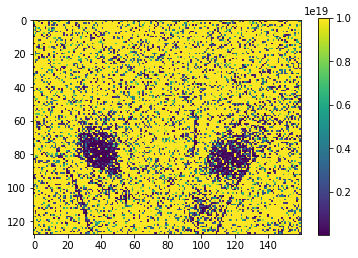

In [36]:
plt.figure()
plt.imshow(m)
plt.colorbar()
plt.clim(1e10,1e19)

## Computation

In [1]:
class ThermalData():
        
    def __init__(self, x, dt):
        
        self.x = x
        self.dt = dt

    
    def _find_nearest(self, array, value):
        
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        
        return array[idx], idx
    
    def get_life(self, C, k, method = None, f = None, location = None, f_span = None):
        
        if method == None:
            method = 'TovoBenasciutti'
            
        if method not in ['Modal', 'TovoBenasciutti', 'Dirlik', 'Rainflow']:
            raise ValueError('Method must be one of: Modal, TovoBenasciutti, Dirlik, Rainflow')
        
        N = self.x.shape[0]
        dt = 1 / fs
        ds = self.x - self.x[0,:,:]
        
        if location is not None:
            (x, y, w, h) = location    
            ds = ds[:, y:(y+h), x:(x+w)]
        
        life = np.zeros(shape=(ds.shape[1], ds.shape[2]))
        npixels = ds.shape[1] * ds.shape[2]  
        
        if method == 'Modal':
            
            if f == None:
                raise ValueError('Natural frequency must be defined')
                
            with tqdm(total = npixels) as pbar:   
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):    
                        
                        fft  = np.abs(np.fft.rfft(ds[:,i,j], N) * 2 / N)
                        freq = np.fft.rfftfreq(N, 1/fs)
            
                        if f_span is not None:
                            x_peak = freq[(freq >= f - f_span) & (freq <= f + f_span)]
                            y_peak = fft[(freq >= f - f_span) & (freq <= f + f_span)]
                            damage = np.sum(x_peak / (C / y_peak**k))
                            
                        else:
                            x_peak = self._find_nearest(freq, f)[0]    
                            y_peak = fft[self._find_nearest(freq, f)[1]]    
                            damage = x_peak / (C / y_peak**k)
            
                        life[i,j] = 1 / damage
                        pbar.update(1)
        
        elif method == 'TovoBenasciutti':
            
            with tqdm(total = npixels) as pbar:
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        
                        tb = FLife.TovoBenasciutti(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = tb.get_life(C = C, k = k, method = "method 2")
                        pbar.update(1)
                    
        elif method == 'Dirlik':
            
            with tqdm(total = npixels) as pbar:
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        
                        dirlik = FLife.Dirlik(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = dirlik.get_life(C = C, k = k)
                        pbar.update(1)
                    
        elif method == 'Rainflow':
            
            with tqdm(total = npixels) as pbar:    
                for i in range(ds.shape[1]):
                    for j in range(ds.shape[2]):
                        
                        rf = FLife.Rainflow(FLife.SpectralData(ds[:,i,j], self.dt))
                        life[i,j] = rf.get_life(C = C, k = k)
                        pbar.update(1)

        if location is not None:
            return np.mean(life, axis = (0,1))
        else:
            return life